In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("/content/engineered_features.parquet")
structured_features = joblib.load("/content/feature_names.json")

X_structured = df[structured_features]
print("Structured input shape:", X_structured.shape)

Structured input shape: (9480, 18)


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)

In [4]:
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_model.fit(X_scaled)

df['isolation_score'] = iso_model.decision_function(X_scaled)
df['isolation_flag'] = iso_model.predict(X_scaled)  # -1 = anomaly, 1 = normal
df['isolation_flag'] = df['isolation_flag'].map({1: 0, -1: 1})  # Convert to binary

In [5]:
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(X_scaled)

df['svm_score'] = svm_model.decision_function(X_scaled)
df['svm_flag'] = svm_model.predict(X_scaled)  # -1 = anomaly, 1 = normal
df['svm_flag'] = df['svm_flag'].map({1: 0, -1: 1})

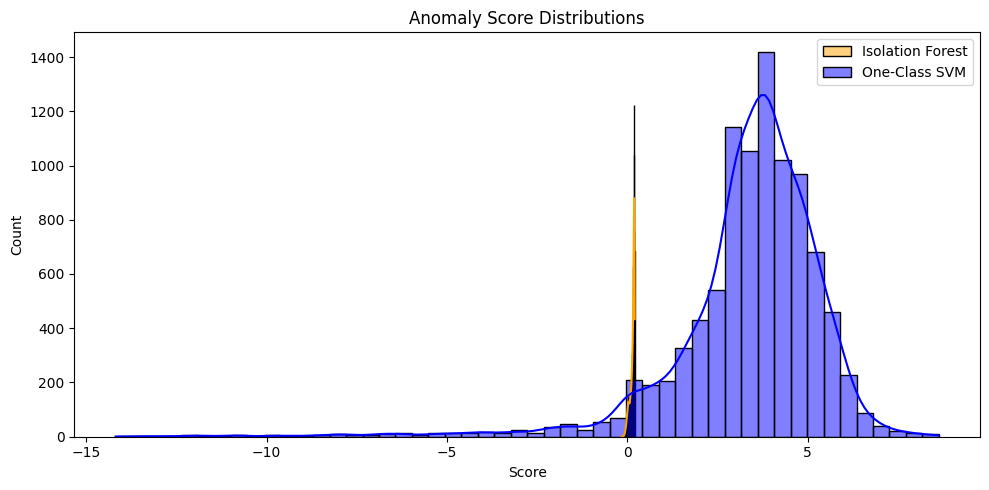

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['isolation_score'], bins=50, kde=True, color='orange', label='Isolation Forest')
sns.histplot(df['svm_score'], bins=50, kde=True, color='blue', label='One-Class SVM')
plt.title("Anomaly Score Distributions")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
df['anomaly_agreement'] = (df['isolation_flag'] == df['svm_flag']).astype(int)
print("Agreement between models:\n", df['anomaly_agreement'].value_counts())

Agreement between models:
 anomaly_agreement
1    9107
0     373
Name: count, dtype: int64


In [8]:
# flag if either model detects anomaly
df['anomaly_flag_combined'] = ((df['isolation_flag'] + df['svm_flag']) > 0).astype(int)

In [9]:
df[['id', 'isolation_flag', 'svm_flag', 'anomaly_flag_combined']].to_parquet("/content/anomaly_flags.parquet", index=False)
joblib.dump(iso_model, "/content/isolation_forest_model.pkl")
joblib.dump(svm_model, "/content/one_class_svm_model.pkl")

['/content/one_class_svm_model.pkl']